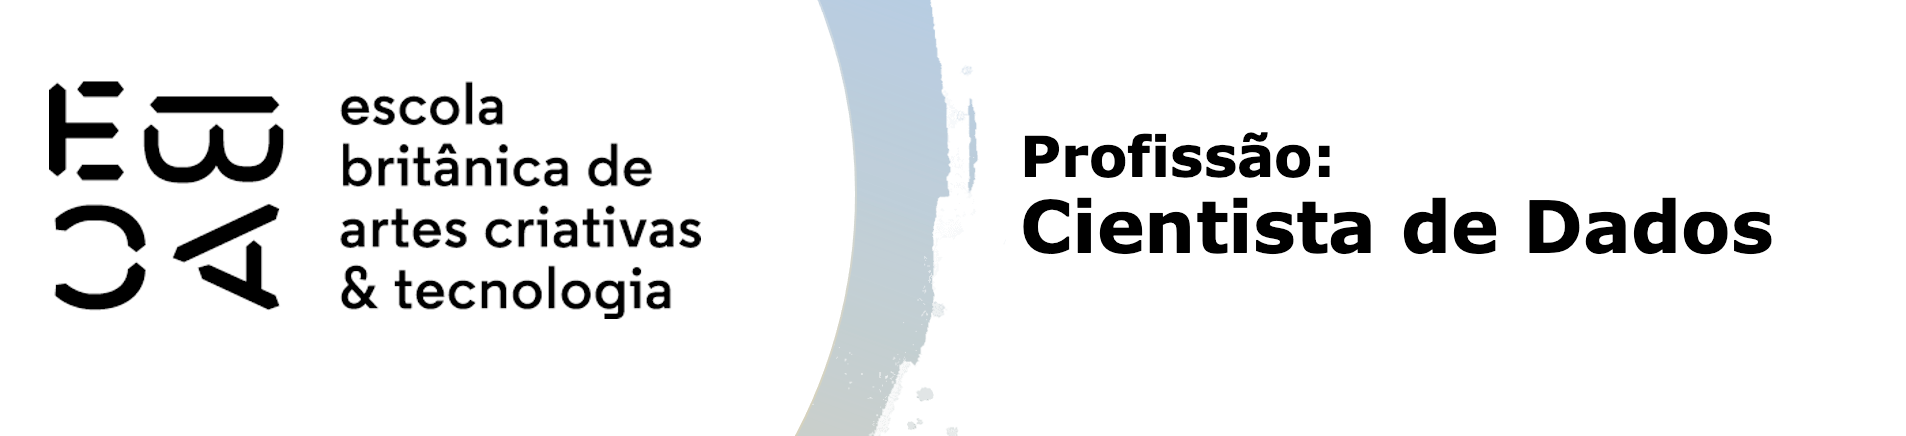

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | * Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from gower import gower_matrix
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

**Verificando valores missing**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Podemos verificar que não há valores missing na base de dados.
    
</div>

**Análise das variáveis referentes a quantidade e tempo de acecsso por página**

In [5]:
# função para criar e retornar um DataFrame por tipo de página
# com a informação de quantidade e duração organizada em linhas e não por colunas

def criar_pagina_df(nome):
    nome_coluna_duracao = f'{nome}_Duration'
    d = df[[nome, nome_coluna_duracao]].copy()
    d.rename(columns={nome: 'quantidade', nome_coluna_duracao: 'duracao'}, inplace=True)
    d['pagina'] = nome
    return d

In [6]:
# cria um novo DataFrame com as informações dos tipos de páginas organizadas em linhas e não por colunas

product = criar_pagina_df('ProductRelated')
informational = criar_pagina_df('Informational')
administrative = criar_pagina_df('Administrative')
df_paginas = pd.concat([administrative, informational, product])

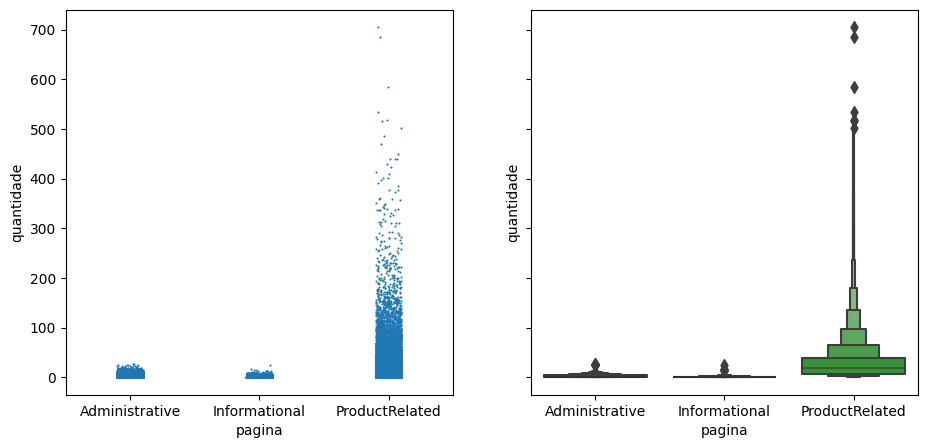

In [7]:
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(11, 5))
sns.stripplot(data=df_paginas, y='quantidade', x='pagina', ax=ax[0], s=1.5)
sns.boxenplot(data=df_paginas, y='quantidade', x='pagina', ax=ax[1])
plt.show()

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

O gráfico acima exibe a relação entre a quantidade de acessos por usuário em cada tipo de página. Podemos verificar que a maior parte dos usuários acessa a página de produtos, com a maioria dos casos com até 200 acessos por usuário. 
    
</div>

In [8]:
df_paginas[['pagina', 'duracao']].groupby('pagina').agg(['mean', 'median', 'std', 'min', 'max'])

duracao                                           
                       mean      median          std  min          max
pagina                                                                
Administrative    80.818611    7.500000   176.779107  0.0   3398.75000
Informational     34.472398    0.000000   140.749294  0.0   2549.37500
ProductRelated  1194.746220  598.936905  1913.669288  0.0  63973.52223

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Na tabela acima temos a média, mediana, o desvio padrão, o mínimo e máximo referente ao tempo de acesso a cada tipo de página. Observando a média e mediana, verificamos que os usuários permanecem na página de produtos por mais tempo. 
    
</div>

**Análise das variáveis referentes ao mês, datas festivas e compra**

In [9]:
# cópia do Dataframe
df_session = df.copy()

# total da quantidade de acessos da sessão
df_session['Quantidade de acessos'] = \
    df_session['Administrative'] + \
    df_session['Informational'] + \
    df_session['ProductRelated']

# total do tempo de acesso da sessão
df_session['Tempo de acesso'] = \
    df_session['Administrative_Duration'] + \
    df_session['Informational_Duration'] + \
    df_session['ProductRelated_Duration']

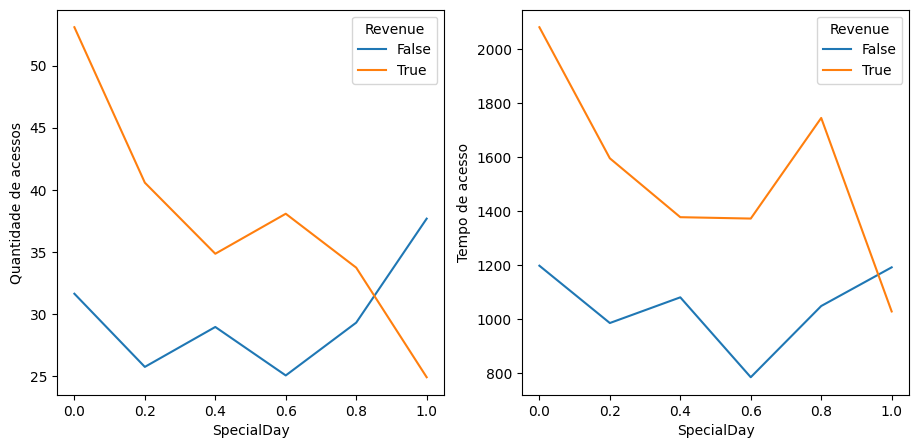

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.lineplot(data=df_session, x="SpecialDay", y="Quantidade de acessos", hue='Revenue', errorbar=None, ax=ax[0])
sns.lineplot(data=df_session, x="SpecialDay", y="Tempo de acesso", hue='Revenue', errorbar=None, ax=ax[1])
plt.show()

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">



No gráfico acima, podemos observar que a relação entre a quantidade e tempo de acesso ao site com a proximidade de uma data festiva.

Podemos ver que a quantidade de acessos daqueles que não compraram aumenta com a proximidade do dia festivo. Já entre aqueles que compraram, a quantidade de acessos vem caindo com a proximidade do dia. Isso pode indicar que aqueles que compraram realizaram o pedido com antecedência.

    
</div>

**Análise das variáveis referentes ao mês e compra apenas em datas festivas**

In [11]:
# cópia do dataframe
df_month = df_session.copy()

In [12]:
# ordena os dados por mês
df_month['Month'] = pd.Categorical(df_month['Month'], ['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
df_month.sort_values("Month", inplace=True)

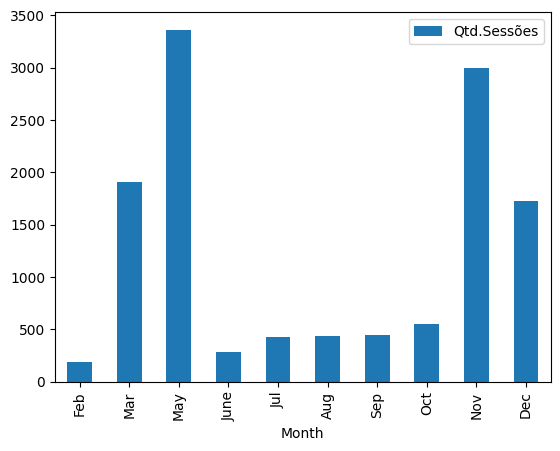

In [13]:
(df_month
    .reset_index()[['Month', 'index']]
    .groupby('Month')
    .count()
    .rename(columns={'index': 'Qtd.Sessões'})
    .plot
    .bar());

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">



No gráfico acima, podemos observar a quantidade de sessões por mês. Podemos ver que os meses com maior movimento no site são os meses de maio e novembro. Provavelmente um reflexo do Dia das Mães e da Black Friday, eventos que ocorrem respectivamente nesses meses.



    
</div>

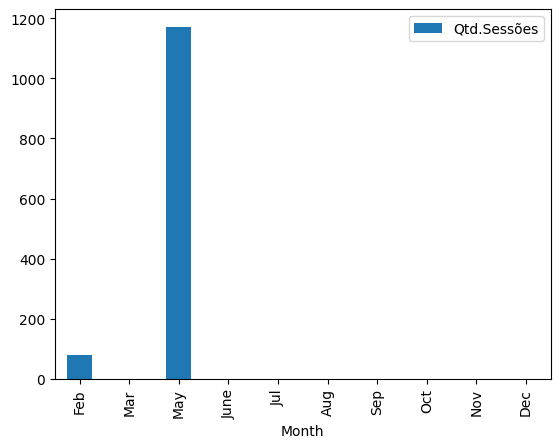

In [14]:
(df_month
    .query('SpecialDay > 0')
    .reset_index()[['Month', 'index']]
    .groupby('Month')
    .count()
    .rename(columns={'index': 'Qtd.Sessões'})
    .plot
    .bar());

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">



No gráfico acima, podemos observar a quantidade de sessões nos meses com data festiva. Temos na base de dados apenas os meses de fevereiro e maio, Dia dos Namorados e Dia das Mães, respectivamente.




    
</div>

**Quantidade e tempo de acesso: Dia dos Namorados**

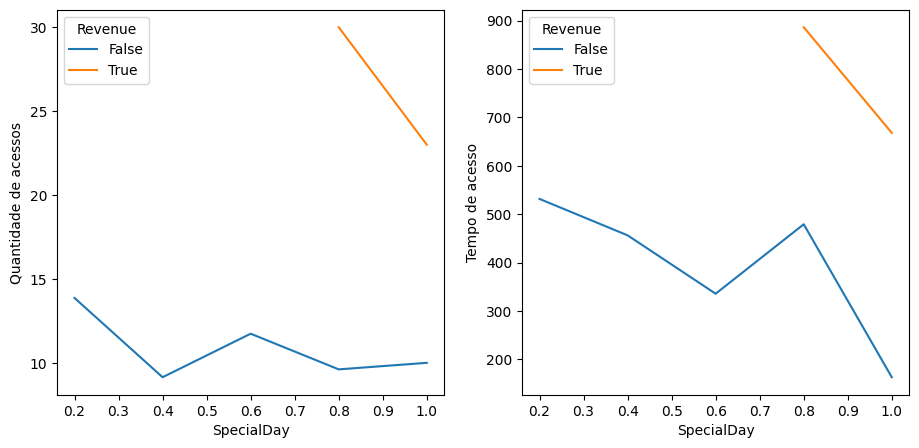

In [15]:
df_month_feb = df_month.query('Month == "Feb" and SpecialDay > 0')
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.lineplot(data=df_month_feb, x="SpecialDay", y="Quantidade de acessos", hue='Revenue', errorbar=None, ax=ax[0])
sns.lineplot(data=df_month_feb, x="SpecialDay", y="Tempo de acesso", hue='Revenue', errorbar=None, ax=ax[1])
plt.show()

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">



Acima podemos ver a quantidade e o tempo de acesso nos dias que antecedem o Dia dos Namorados. Fica claro que aqueles que realizam uma compra, deixam para fazer até 2 dias antes da data. O tempo de acesso ao site também não é muito grande. Isso pode indicar que a compra realizada é de um produto que já pensado previamente ou que o usuário realiza a compra de qualquer produto para presentear.



    
</div>

**Quantidade e tempo de acesso: Dia das Mães**

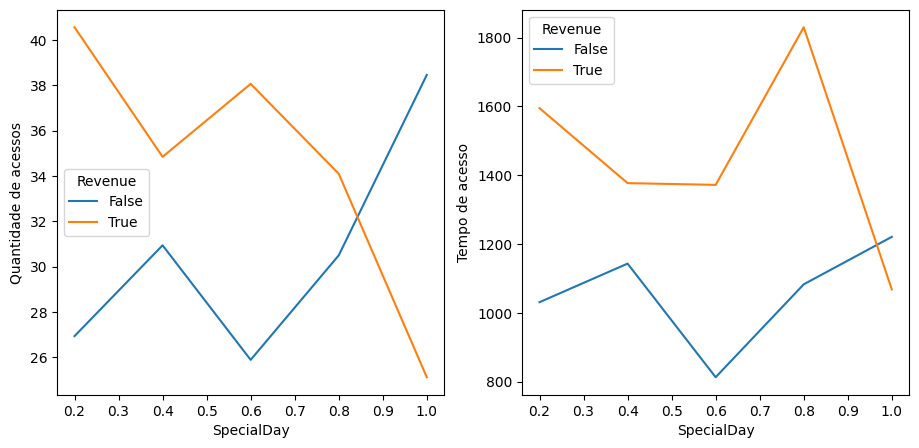

In [16]:
df_month_may = df_month.query('Month == "May" and SpecialDay > 0')
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.lineplot(data=df_month_may, x="SpecialDay", y="Quantidade de acessos", hue='Revenue', errorbar=None, ax=ax[0])
sns.lineplot(data=df_month_may, x="SpecialDay", y="Tempo de acesso", hue='Revenue', errorbar=None, ax=ax[1])
plt.show()

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">



Podemos observar nos gráficos acima que os usuários que realizam a compra de um presente para o Dia das Mães o fazem com mais antecedência e pode toda a semana que antecede a data. Esses usuários também passam mais tempo no site em comparação com o Dia dos Namorados.





    
</div>

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [17]:
# O valor da variável 'SpecialDay' está sendo alterado para o tipo boolean
# considerando True como data festiva os registros cujo valor é maior que zero.

df_copy = df.copy()
df_copy['SpecialDay'] = np.where(df_copy['SpecialDay'] > 0, True, False)

In [18]:
# Variáveis qualitativas. Variáveis que indicam a característica da data.
vars_quali = [
    'Month',
    'Weekend',
    'SpecialDay'
]

# Variáveis quantitativas. Variáveis que descrevem o padrão de navegação na sessão.
vars_quanti = [
    'Administrative',
    'Administrative_Duration',
    'Informational',
    'Informational_Duration',
    'ProductRelated',
    'ProductRelated_Duration',
]

# aplicando StandardScaler nas variáveis quantitativas
df_quanti = pd.DataFrame(StandardScaler().fit_transform(df_copy[vars_quanti]), columns=vars_quanti)

# criando os dummies para as variáveis qualitativas
df_quali = pd.get_dummies(df_copy[vars_quali], columns=vars_quali)

# criando o DataFrame padronizado
X_pad = pd.concat([df_quanti, df_quali], axis=1)
X_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Weekend_False,Weekend_True,SpecialDay_False,SpecialDay_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,0,0,1,0,0,0,0,0,0,0,1,0,1,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,0,0,1,0,0,0,0,0,0,0,0,1,1,0


In [19]:
# O código abaixo cria uma lista com o nome das variáveis qualitativas após 
# a padronização do DataFrame usando o get_dummies

vars_quali_names = []
for col_name in X_pad.columns:
    for quali_name in vars_quali:
        if col_name.startswith(quali_name):
            vars_quali_names.append(col_name)
            break

In [20]:
# nome das variáveis qualitativas após o get_dummies
vars_quali_names

['Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'Weekend_False',
 'Weekend_True',
 'SpecialDay_False',
 'SpecialDay_True']

In [21]:
# definindo quais variáveis do DataFrame são categóricas
vars_categoricas = [(x in vars_quali_names) for x in X_pad.columns]
vars_categoricas

[False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [22]:
# calcula a matriz de distâncias utilizando a distância de Gower.

distancia_gower = gower_matrix(X_pad, cat_features=vars_categoricas)

In [23]:
# ajustando o formato da matriz de distâncias

gdv = squareform(distancia_gower, force='tovector')

In [24]:
# ligação entre os pontos com base na matriz de distâncias

Z = linkage(gdv, method='complete')

Leaves = 11306


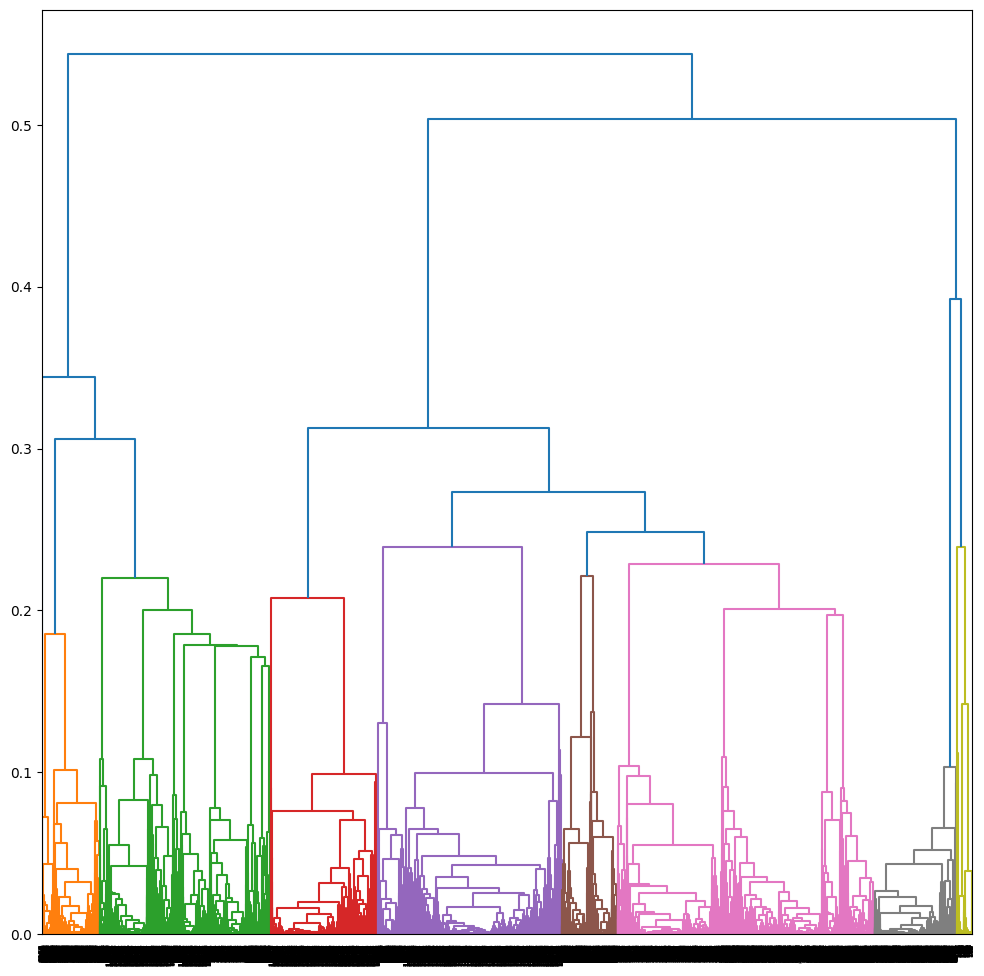

In [108]:
# Dendrograma

fig, axs = plt.subplots(1, 1, figsize=(12,12))
dn = dendrogram(Z, truncate_mode='level', p=30, show_leaf_counts=True, ax=axs, color_threshold=.24)
print(f"Leaves = {len(dn['leaves'])}")

In [25]:
# marcando no Dataframe os grupos nos quais os registros foram classificados
# considerando a formação de 3 grupos (coluna "grupo3") ou 4 grupos (coluna "grupo4")

X_pad['grupo3'] = fcluster(Z, 3, criterion='maxclust')
X_pad['grupo4'] = fcluster(Z, 4, criterion='maxclust')

df_copy['grupo3'] = X_pad['grupo3']
df_copy['grupo4'] = X_pad['grupo4']

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

**Criando um novo DataFrame para a análise descritiva**

In [26]:
# nome das colunas dos meses que foram criadas com o get_dummies
meses = [n for n in X_pad.columns if (n.startswith('Month_'))]

# colunas com as variáveis referentes a quantidade de acessos
df_grupos = df[['Administrative', 'Informational', 'ProductRelated']].copy()

# adiciona a coluna referente a data festiva
df_grupos['SpecialDay'] = df_copy['SpecialDay']

# adiciona a classificação de 3 ou 4 grupos
df_grupos['grupo3'] = df_copy['grupo3']
df_grupos['grupo4'] = df_copy['grupo4']

# cria um DataFrame final
df_grupos = pd.concat([df_grupos, X_pad[meses]], axis=1)

**Agrupamento com 4 grupos**

In [28]:
grupo_com_4 = df_grupos.drop(columns=['grupo3'], axis=1).groupby('grupo4').sum(); grupo_com_4

,Administrative,Informational,ProductRelated,SpecialDay,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
grupo4,,,,,,,,,,,,,,
1,7083,1679,94464,149,96,366,0,104,47,481,715,791,144,96
2,19981,4184,266628,0,337,1361,0,328,241,1426,1626,2207,405,352
3,1382,330,28099,1023,0,0,0,0,0,0,1023,0,0,0
4,100,16,2058,79,0,0,184,0,0,0,0,0,0,0


**Agrupamento com 3 grupos**

In [27]:
grupo_com_3 = df_grupos.drop(columns=['grupo4'], axis=1).groupby('grupo3').sum(); grupo_com_3

,Administrative,Informational,ProductRelated,SpecialDay,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
grupo3,,,,,,,,,,,,,,
1,7083,1679,94464,149,96,366,0,104,47,481,715,791,144,96
2,19981,4184,266628,0,337,1361,0,328,241,1426,1626,2207,405,352
3,1482,346,30157,1102,0,0,184,0,0,0,1023,0,0,0


<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Podemos observar nas tabelas anteriores que a diferença na classificação entre 3 ou 4 grupos está nos meses de fevereiro e maio. Com 4 classificações, o algoritmo cria um grupo exclusivamente para aqueles que acessaram o sistema durante o mês de fevereiro, que tem como data festival o Dia dos Namorados. Nesse caso, a classificação com 3 grupos se mostra mais adequada.
    
</div>

In [40]:
grupo_com_3[['Administrative', 'Informational', 'ProductRelated']]

,Administrative,Informational,ProductRelated
grupo3,,,
1,7083,1679,94464
2,19981,4184,266628
3,1482,346,30157


<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Para cada grupo classificado, de acordo com os dados das tabelas acima, podemos concluir que:
    
- **grupo_2**: grupo dos usuários que acessam a página de produtos. Podemos verificar que esse grupo aparece relacionado a página de produto com relação a maior quantidade de acessos. Também podemos ver que esse grupos possui maior regularidade de acessos durante os meses do ano.<br><br>
    
- **grupo_1**: grupo de usuários que acessam a página administrativa. É o segundo maior grupo em número de acessos e também em regularidade de acessos durante os meses do ano.<br><br> 
    
- **grupo_3**: grupo de usuários que acessam a página informativa. O algoritmo classificou esse grupo como usuários que acessam o sistema apenas nos meses de datas festivas, fevereiro e maio.
    
</div>

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [41]:
# agrupando por grupo é calculando a média, mediana, desvio padrão e valor máximo para BounceRates
# calculando a quantidade de Revenue
df['grupo'] = X_pad['grupo3']

df[['grupo', 'BounceRates', 'Revenue']].groupby('grupo').agg({
    'BounceRates' : ('mean', 'median', 'std', 'max'), 
    'Revenue' : 'count'
})

BounceRates                          Revenue
             mean    median       std  max   count
grupo                                             
1        0.017663  0.002546  0.041916  0.2    2840
2        0.021704  0.002469  0.048912  0.2    8283
3        0.036189  0.011215  0.056782  0.2    1207

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Analisando a mediana da taxa de rejeição (BounceRates) e a quantidade de compras para cada grupo, podemos concluir que o grupo de clientes mais propensos a compra é o grupo de "Produtos". Esse é o grupo com a maior quantidade de compra e a mediana da taxa de rejeição está próxima de zero além de ser a menor entre os grupos.
    
</div>